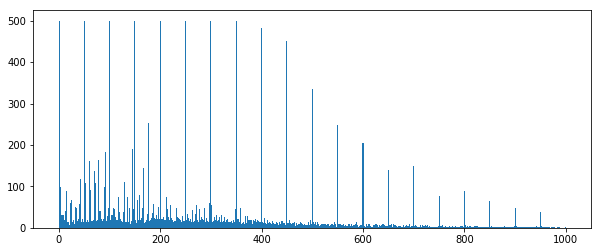

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILEPATH = '/media/vincent/home/data/'
BALANCED_FILE = FILEPATH+'driving_log_balanced.csv'
ORIGINAL_FILE = FILEPATH+'driving_log.csv'
MODELPATH = FILEPATH+'model.h5'

df = pd.read_csv(ORIGINAL_FILE)
df.columns =['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
balanced = pd.DataFrame() 	# Balanced dataset
bins = 1000 				# N of bins
bin_n = 500			# N of examples to include in each bin (at most)

balanced_num =[]
start = 0
for end in np.linspace(0, 1, num=bins):  
    df_range = df[(np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end)]
    range_n = min(bin_n, df_range.shape[0])
    balanced_num.append(range_n)
    if range_n != 0:
        balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end

balanced.to_csv(BALANCED_FILE, index=False)

plt.figure(figsize=(10, 4))
plt.bar(range(len(balanced_num)), balanced_num, width=2)
plt.show()

In [2]:
import cv2
from scipy.misc import imresize

def equal_Hist(img):
    # Equalization Histogram
    img_temp = img.copy()
    img_temp[:,:,0] = cv2.equalizeHist(img[:, :, 0])
    img_temp[:,:,1] = cv2.equalizeHist(img[:, :, 1])
    img_temp[:,:,2] = cv2.equalizeHist(img[:, :, 2])
    return img_temp

def crop(img, margin=0):
    return img[margin:(img.shape[0]-margin), margin:(img.shape[1]-margin)]

def blur(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

def resize(image, new_size): 
    return imresize(image, new_size) 

def shadow(image):
    img = np.copy(image)
    h, w = image.shape[0], image.shape[1]
    [x1, x2] = np.random.choice(w, 2, replace=False)
    k = h / (x2 - x1)
    b = - k * x1
    for i in range(h):
        c = int((i - b) / k)
        img[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
    return img


def random_gamma(image):
    """
    Random gamma correction is used as an alternative method changing the brightness of
    training images.
    http://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
    :param image:
        Source image
    :return:
        New image generated by applying gamma correction to the source image
    """
    gamma = np.random.uniform(0.4, 1.5)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


def process(img):
    result = random_gamma(img)
    result = shadow(result)
    result = resize(result, (80, 160, 3))
    result = blur(result)
    
    #result = blur(img)
    result = equal_Hist(result)

    return result


In [3]:
import os
import csv

samples = []
with open(BALANCED_FILE) as csvfile:
    reader = csv.reader(csvfile)
    
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples[1:], test_size=0.2)

import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle

In [4]:
def load_data(lines, batch_size=32):
    adjust_angle=[0, 0.2, -0.2]
    while True:
        shuffle(lines)
        x_batch, y_batch = [], []
        idx = 0
        for line in lines:
            #for i in range(3):
            i = np.random.randint(0, 3)
            name = FILEPATH+'IMG/'+line[i].split('/')[-1]
            image = cv2.imread(name)
            processed_image = process(image)
            #print(np.array(processed_image).shape)

            angle = float(line[3])

            x_batch.append(processed_image)
            y_batch.append(angle+adjust_angle[i])

            x_batch.append(cv2.flip(processed_image,1))
            y_batch.append((angle+adjust_angle[i])*-1.0)

            idx += 1

            if idx == batch_size:
                yield np.array(x_batch), np.array(y_batch)
                x_batch, y_batch = [], []
                idx = 0

train_generator = load_data(train_samples, batch_size=32)
validation_generator = load_data(validation_samples, batch_size=32)

In [5]:
"""
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, Dropout,
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D

model = Sequential()
model.add(Lambda(lambda x:x/255.0-0.5, input_shape=(80, 160, 3)))
model.add(Cropping2D(cropping=((35,12), (0,0))))
#model.add(Lambda(lambda x:x/255.0-0.5, input_shape=(160, 320, 3)))
#model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(500))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dense(1))

#model.load_weights(MODELPATH)
model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, steps_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=3)

model.save(MODELPATH)
#exit()
"""

"\nfrom keras.models import Sequential\nfrom keras.layers import Flatten, Dense, Lambda\nfrom keras.layers import Conv2D, Dropout,\nfrom keras.layers.pooling import MaxPooling2D\nfrom keras.layers import Cropping2D\n\nmodel = Sequential()\nmodel.add(Lambda(lambda x:x/255.0-0.5, input_shape=(80, 160, 3)))\nmodel.add(Cropping2D(cropping=((35,12), (0,0))))\n#model.add(Lambda(lambda x:x/255.0-0.5, input_shape=(160, 320, 3)))\n#model.add(Cropping2D(cropping=((70,25), (0,0))))\n\nmodel.add(Conv2D(16,(3,3),activation='relu'))\nmodel.add(MaxPooling2D(2,2))\nmodel.add(Conv2D(32,(3,3),activation='relu'))\nmodel.add(MaxPooling2D(2,2))\nmodel.add(Conv2D(64,(3,3),activation='relu'))\nmodel.add(MaxPooling2D(2,2))\n\nmodel.add(Flatten())\nmodel.add(Dense(500))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(100))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(20))\nmodel.add(Dense(1))\n\n#model.load_weights(MODELPATH)\nmodel.compile(loss='mse', optimizer='adam')\nmodel.fit_generator(train_generator, steps_per_e

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, Dropout,Convolution2D,Activation
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Lambda(lambda x:x/255.0-0.5, input_shape=(80, 160, 3)))
model.add(Cropping2D(cropping=((35,12), (0,0))))

model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation(activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation(activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Flatten())

# Next, five fully connected layers
model.add(Dense(1024))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(500))
model.add(Activation(activation="relu"))

model.add(Dense(100))
model.add(Activation(activation="relu"))

model.add(Dense(10))
model.add(Activation(activation="relu"))

model.add(Dense(1))
    
checkpointer = ModelCheckpoint(FILEPATH+'weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


#model.load_weights(MODELPATH)
model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, steps_per_epoch= int(len(train_samples)/10), 
                    validation_data=validation_generator, nb_val_samples=len(validation_samples),
                    nb_epoch=20, callbacks=[checkpointer])

#model.save(MODELPATH)
#exit()

Using TensorFlow backend.
/home/vincent/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), padding="same")`
  if sys.path[0] == '':
/home/vincent/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), padding="same")`
  app.launch_new_instance()
/home/vincent/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), padding="same")`
/home/vincent/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
/home/vincent/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:28: User

Epoch 1/20
1459/1459 [==============================] - 435s - loss: 0.0667 - val_loss: 0.0597
Epoch 2/20
1459/1459 [==============================] - 418s - loss: 0.0559 - val_loss: 0.0575
Epoch 3/20
1459/1459 [==============================] - 416s - loss: 0.0545 - val_loss: 0.0539
Epoch 4/20
1459/1459 [==============================] - 416s - loss: 0.0524 - val_loss: 0.0529
Epoch 5/20
1459/1459 [==============================] - 419s - loss: 0.0518 - val_loss: 0.0532
Epoch 6/20
1459/1459 [==============================] - 419s - loss: 0.0503 - val_loss: 0.0516
Epoch 7/20
1459/1459 [==============================] - 421s - loss: 0.0492 - val_loss: 0.0511
Epoch 8/20
1459/1459 [==============================] - 428s - loss: 0.0484 - val_loss: 0.0503
Epoch 9/20
1459/1459 [==============================] - 428s - loss: 0.0479 - val_loss: 0.0526
Epoch 10/20
1459/1459 [==============================] - 427s - loss: 0.0474 - val_loss: 0.0507
Epoch 11/20
1459/1459 [==========================

In [7]:
exit()